<a href="https://colab.research.google.com/github/ANGADJEET/ANGADJEET/blob/main/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune the Vision Transformer on CIFAR-10

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which I added to [🤗 Transformers](https://github.com/huggingface/transformers)) on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset is a collection of 60,000 32x32 colour images in 10 classes, with 6000 images per class.

We will prepare the data using [🤗 datasets](https://github.com/huggingface/datasets), and train the model using [PyTorch Lightning ⚡](https://github.com/PyTorchLightning/pytorch-lightning). Note that I also have a notbook that leverages the HuggingFace Trainer. You can find it in mmy repo [Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials).

### Quick intro: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

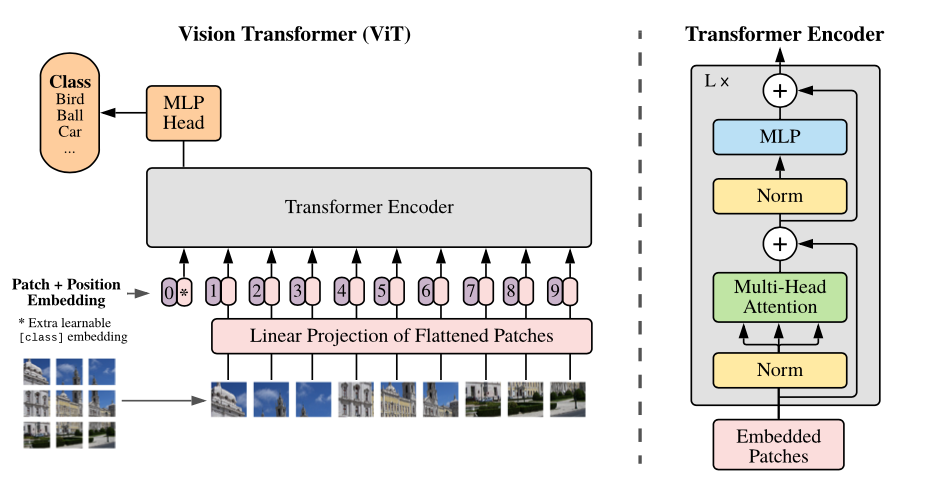

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


Let's start by installing the relevant libraries.

In [1]:
!pip install -q transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 23.3 MB/s eta 0:00:00


## Load the data

Here we import a small portion of CIFAR-10, for demonstration purposes. This dataset can be found on the [hub](https://huggingface.co/datasets/cifar10) (you can view images directly in your browser!).

In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ValueError: Invalid pattern: '**' can only be an entire path component

In [ ]:
train_ds

We can also check out the features of the dataset in more detail:

In [ ]:
train_ds.features

As we can see, each example has 2 features: 'img' (of type `Image`) and 'label' (of type `ClassLabel`). Let's check an example of the training dataset:

In [ ]:
train_ds[0]['img']

In [ ]:
train_ds[0]['label']

Of course, we would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

In [ ]:
id2label[train_ds[0]['label']]

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`.

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

We first load the image processor, which is a minimal object that can be used to prepare images for inference. We use some of its properties which are relevant for preparing images for the model.

In [ ]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [ ]:
train_ds[:2]

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

In [ ]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [ ]:
next(iter(val_dataloader))['pixel_values'].shape

## Define the model

Here we define a `LightningModule`, which is very similar to a regular `nn.Module`, but with some additional functionalities.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

A resource that helped me in understanding PyTorch Lightning is the [documentation](https://pytorch-lightning.readthedocs.io/en/latest/index.html) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/pytorch-lightning/tree/master/notebooks).

In [ ]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

Let's first start up Tensorboard (note that PyTorch Lightning logs to Tensorboard by default):

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Let's initialize the model, and train it!

We also add a callback:
* early stopping (stop training once the validation loss stops improving after 3 times).

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(gpus=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Finally, let's test the trained model on the test set:

In [ ]:
trainer.test()